In [11]:
import os, random
import numpy as np
import pandas as pd
import imghdr
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, BatchNormalization, Dropout

# Importing warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
image_types= ['jpeg','png', 'jpg']
for root, dirs, files in os.walk('train'):
    for file in files:
        file_path = os.path.join(root, file)
        image_type = imghdr.what(file_path)
        if image_type not in image_types:
            print('File name : '.format(file, image_type))
        else:
            cv2.imread(file_path)

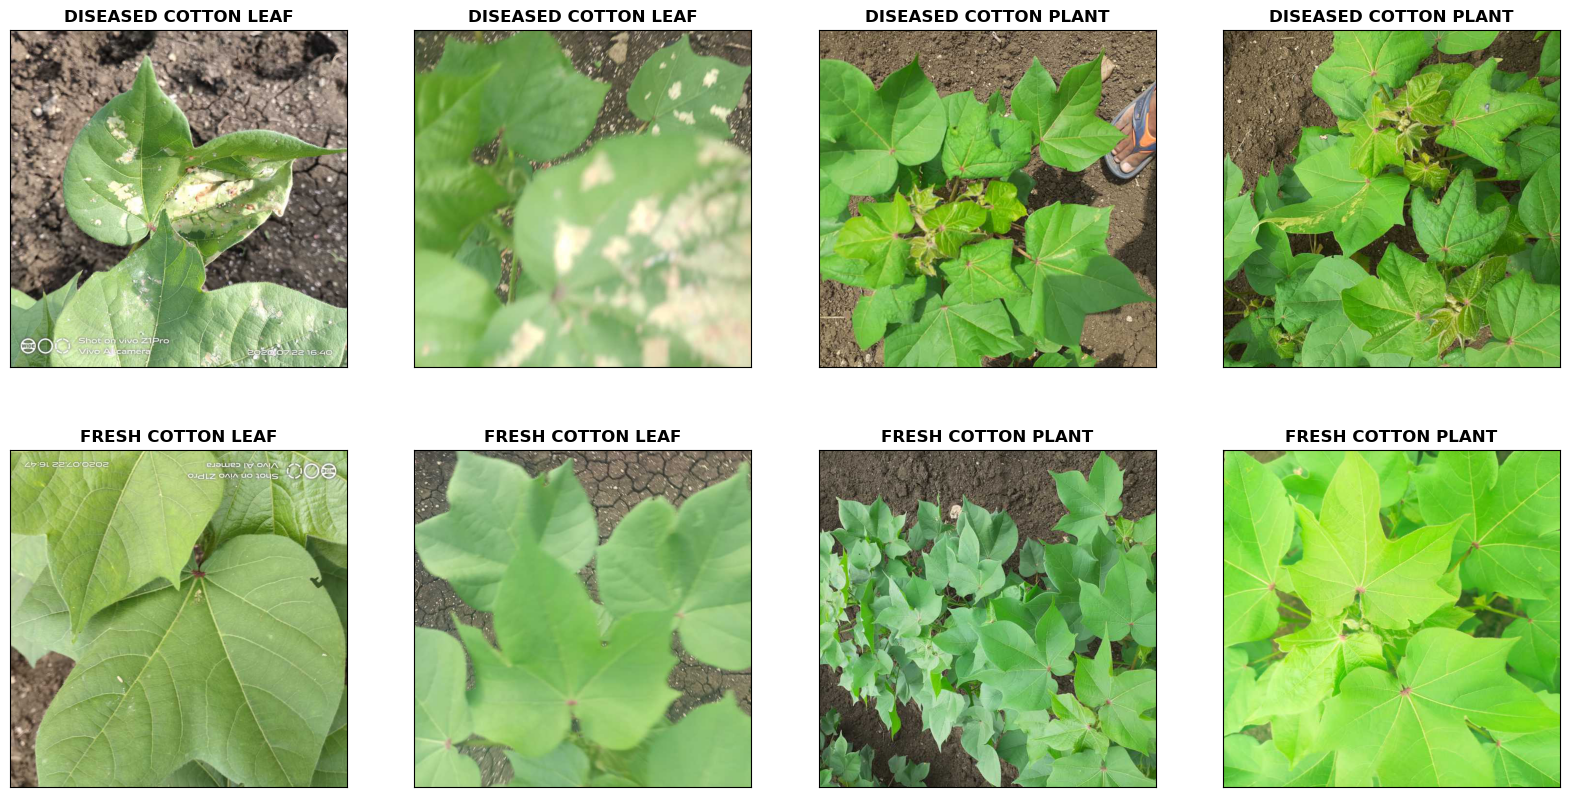

In [5]:
fig, axes = plt.subplots(2,4, figsize=(20,10))
ax = axes.ravel()
i=0
path = 'Cotton Disease/train'
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    image = os.listdir(folder_path)
    selected_img = random.sample(image,2)
    
    for image in selected_img:
        img_path = os.path.join(folder_path, image)
        img = plt.imread(img_path)
        ax[i].set_title(folder.upper(),fontweight='bold')
        ax[i].imshow(img)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        i=i+1

Number of Images in diseased cotton leaf : 288
Number of Images in diseased cotton plant : 815
Number of Images in fresh cotton leaf : 427
Number of Images in fresh cotton plant : 420


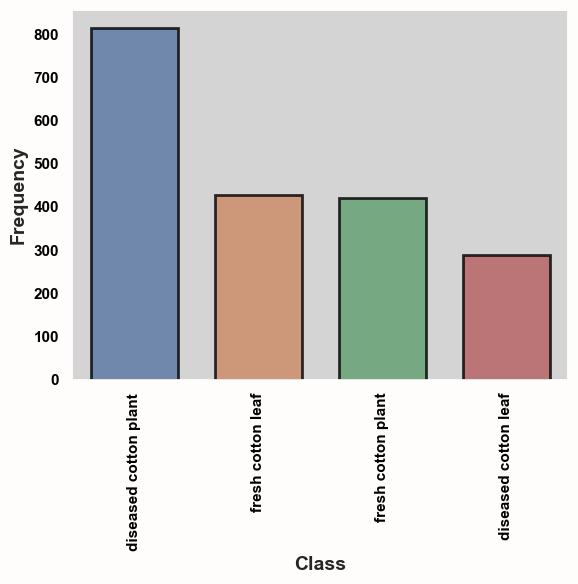

In [7]:
sns.set_theme(rc={'axes.facecolor':'#d4d4d4','figure.facecolor':'#fffcfc'})

def images_count(path):
    count = {}
    for folder in os.listdir(path):
        folder_Path = os.path.join(path,folder)
        if os.path.isdir(folder_Path):
            count[folder]=len(os.listdir(folder_Path))
            print(f'\033[1mNumber of Images in {folder} : {count[folder]}\033[0m')
            df = pd.DataFrame(count,index=[folder]).melt(var_name='class').sort_values(by='value',ascending=False)
    return df
        
class_count = images_count('Cotton Disease/train')
sns.barplot(class_count, x='class', y='value', width=0.7, edgecolor='black', linewidth=2, alpha=0.8)
plt.xticks(rotation=90,color='black',weight='bold')
plt.yticks(color='black',weight='bold')
plt.xlabel('Class', weight='bold', fontsize=14)
plt.ylabel('Frequency',weight='bold', fontsize=14)
plt.grid(False)

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(directory='Cotton Disease/train', labels='inferred', label_mode='categorical',
                                                       batch_size=15, image_size=(256,256),seed=123, shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(directory='Cotton Disease/val', labels='inferred', label_mode='categorical',
                                                       batch_size=15, image_size=(256,256),seed=123, shuffle=True)

Found 1950 files belonging to 4 classes.
Found 253 files belonging to 4 classes.


In [12]:
classes = train_ds.class_names
print(classes)

['diseased cotton leaf', 'diseased cotton plant', 'fresh cotton leaf', 'fresh cotton plant']


In [13]:
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)

(15, 256, 256, 3)
(15, 4)


In [14]:
train_ds = train_ds.map(lambda x, y : (x/255,y))
val_ds = val_ds.map(lambda x, y : (x/255,y))

In [15]:
model = Sequential()

model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(16, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())
# model.add(Dense(128,activation='relu'))
model.add(Dense(4, activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      73792     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     256       
 hNormalization)                                                 
                                                        

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
callbacks = EarlyStopping(monitor='val_accuracy', patience=3, verbose=2,
                            mode='max', restore_best_weights=True)

In [19]:
history = model.fit(train_ds, validation_data=val_ds,epochs=14, callbacks=[callbacks])

Epoch 1/14
130/130 [==============================] - 517s 4s/step - loss: 0.8324 - accuracy: 0.7236 - val_loss: 1.4313 - val_accuracy: 0.3834
Epoch 2/14
130/130 [==============================] - 824s 6s/step - loss: 0.3939 - accuracy: 0.8605 - val_loss: 1.3883 - val_accuracy: 0.5020
Epoch 3/14
130/130 [==============================] - 309s 2s/step - loss: 0.2986 - accuracy: 0.8877 - val_loss: 1.0002 - val_accuracy: 0.6324
Epoch 4/14
130/130 [==============================] - 341s 3s/step - loss: 0.2074 - accuracy: 0.9185 - val_loss: 0.3938 - val_accuracy: 0.8538
Epoch 5/14
130/130 [==============================] - 340s 3s/step - loss: 0.1220 - accuracy: 0.9564 - val_loss: 0.2921 - val_accuracy: 0.8735
Epoch 6/14
130/130 [==============================] - 322s 2s/step - loss: 0.0895 - accuracy: 0.9662 - val_loss: 0.3346 - val_accuracy: 0.8617
Epoch 7/14
130/130 [==============================] - 352s 3s/step - loss: 0.0668 - accuracy: 0.9795 - val_loss: 0.3285 - val_accuracy: 0.9170

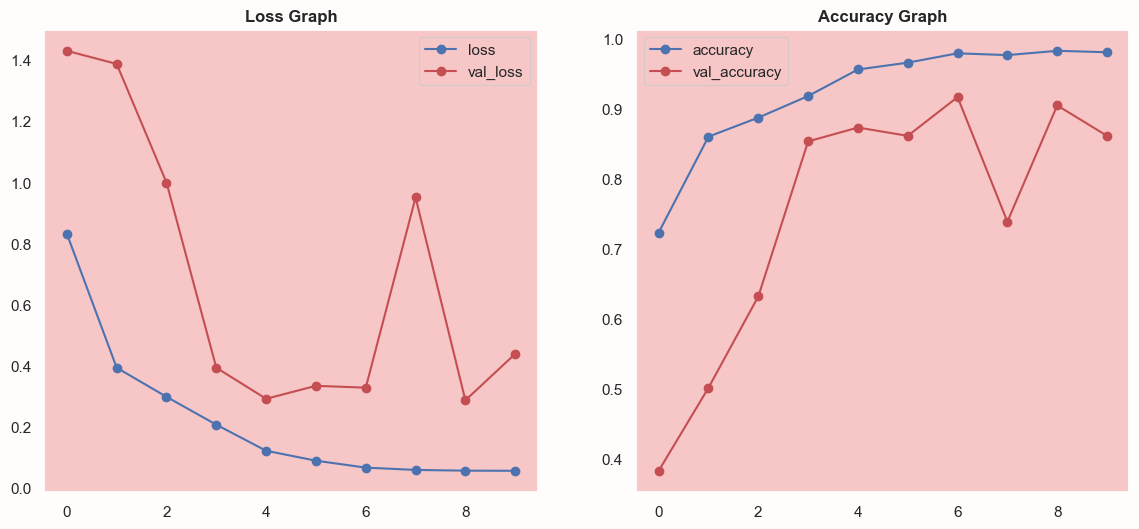

In [20]:
sns.set_theme(rc={'axes.facecolor':'#f7c6c6','figure.facecolor':'#fffcfc'})

fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(history.history['loss'],label='loss', marker='o', color='b')
ax[0].plot(history.history['val_loss'],label='val_loss', marker='o', color='r')
ax[0].set_title('Loss Graph',fontweight='bold')
ax[0].legend()
ax[0].grid(False)

ax[1].plot(history.history['accuracy'],label='accuracy',marker='o', color='b')
ax[1].plot(history.history['val_accuracy'],label='val_accuracy',marker='o', color='r')
ax[1].set_title('Accuracy Graph',fontweight='bold')
ax[1].legend()
ax[1].grid(False)

plt.show()

In [21]:
model.save('cotton_disease_detection.h5')

In [19]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

In [23]:
def image_preprocessing(image):
    image = Image.open(image)
    image = image.resize((256,256),Image.Resampling.NEAREST)
    image_array = np.array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = image_array/255
    return image_array

In [22]:
image = 'dis_leaf (309)_iaip.jpg'
processed_image = image_preprocessing(image)

In [25]:
model1 = load_model('cotton_disease_detection.h5')
prediction = model1.predict(processed_image)

1/1 [==============================] - 0s 301ms/step


In [31]:
print(prediction)

[[9.9986863e-01 2.2858815e-06 3.2001036e-08 1.2913519e-04]]


In [33]:
predicted_class = np.argmax(prediction, axis=1)[0]
print(predicted_class)

0
